### Spoofing Case Grouping

In [1]:
import os; os.chdir('/Users/sqian/MKTSRV')
import pandas as pd; pd.set_option('mode.chained_assignment',None) 
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import math
import re
import xlrd
from xlsxwriter.utility import xl_rowcol_to_cell

from src.data_models.smartshelper import metrics, fixType, unSMART, cparty
from src.data_models.SmartsDataModel import SmartsDataModel

/Users/sqian/.pyenv/versions/3.7.0/envs/env_370/lib/python3.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


#### 0) Data Prep

In [2]:
rawalerts = unSMART(pd.read_excel('~/Documents/datafldr/smarts1_2019JanFeb.xlsx'))

-> type fixed, kept 307 rows, 48 columns


#### 1) Variables

In [3]:
newdf = rawalerts.loc[rawalerts['AlertCode'] == 4032].reset_index(drop=True)
newdf['AccountID'] = newdf['AccountIDCode'].astype(int)

newdf.groupby([newdf['Datetime'].dt.month.rename('month'),'ShortText']).count()['AlertID']

month  ShortText               
1      MULTI ORDER SPOOFING        19
       MULTI ORDER SPOOFING EOD    30
2      MULTI ORDER SPOOFING        13
       MULTI ORDER SPOOFING EOD    27
Name: AlertID, dtype: int64

In [4]:
newdf2 = newdf.loc[newdf['ShortText'] == 'MULTI ORDER SPOOFING'].reset_index(drop=True)

newdf2.groupby([newdf2['Datetime'].dt.month.rename('month'),'AccountID','InstrumentName']).count()['AlertID']

df_acc_pair = pd.pivot_table(newdf2, values='AlertID', index=['month','InstrumentName'], columns=['AccountID'], aggfunc=np.sum).fillna(value=0).astype(int)
df_acc_pair['Total'] = df_acc_pair.sum(axis=1)

print(df_acc_pair)
for i in range(1,2): print(newdf2.loc[i,'LongText'],'\n\n')

AccountID             22440  355845  Total
month InstrumentName                      
1     BTCUSD             25       1     26
      ETHUSD              0       4      4
2     BTCUSD             20      10     30
      ETHUSD              0      31     31
MULTI ORDER SPOOFING: Broker 355845 has been involved in a suspected spoofing activity on security BTCUSD. Spoofing sell orders: Entry to spoofing candidate : 04:54:03.035 Deleted : 04:54:04.042 Volume x0.976 Price 3980.47000 Entry to spoofing candidate : 04:54:04.042 Deleted : 04:54:04.565 Volume x0.886 Price 3980.36000 Entry to spoofing candidate : 04:54:04.565 Deleted : 04:54:05.527 Volume x0.838 Price 3979.73000 Entry to spoofing candidate : 04:54:05.527 Deleted : 04:54:05.550 Volume x0.919 Price 3979.28000 Entry to spoofing candidate : 04:54:05.550 Deleted : 04:54:07.317 Volume x0.602 Price 3979.23000 Entry to spoofing candidate : 04:54:07.292 Deleted : 04:54:07.317 Volume x7.499 Price 3978.29000 Entry to spoofing candidate : 0

In [5]:
regex4032 = '\D+(\d+)\D+([A-Z]{6})\D+orders:\s(.+).+Genuine.+traded\D+([\d:]+\.\d+)\D+ratio\D+([\d.,]+)\D+([\d.,]+)\D+([\d.,]+)\.\D+([\d.,]+)\D+([\d.,]+)\D+[\d.,]+\.\D+[\d.,]+\.\D+([\d,]+)\.'
name4032 = {0:'acc', 1:'security', 2:'spoofs', 3:'timeGenuine', 4:'volGenuine', 5:'volmaxSpoof', 6:'ratio', 7:'price0', 8:'price1', 9:'cumulative'}
regex4032_spoof = 'Entry\D+([\d.:]+)\sDeleted\D+([\d.:]+)\D+([\d.,]+)\D+([\d.,]+)\s'

expanded = newdf2['LongText'].str.extract(regex4032, expand=True).rename(columns=name4032)
expanded['spoofs'] = expanded['spoofs'].str.findall(regex4032_spoof)
expanded['countspoofs'] = expanded['spoofs'].apply(len)

newdf3 = pd.concat([newdf2['Datetime'],expanded],axis=1)
newdf3.head()

,Datetime,acc,security,spoofs,timeGenuine,volGenuine,volmaxSpoof,ratio,price0,price1,cumulative,countspoofs
0,2019-01-01 18:19:05,22440,BTCUSD,"[(18:18:59.239, 18:18:59.688, 0.5, 3748.16000)...",18:19:03.668,0.683733,10.662674,15.594795,3748.00000,3756.29000,54,12
1,2019-01-07 04:54:10,355845,BTCUSD,"[(04:54:03.035, 04:54:04.042, 0.976, 3980.4700...",04:54:08.463,0.633,8.101,12.797788,3980.50000,3971.05000,6,11
2,2019-01-10 11:09:41,22440,BTCUSD,"[(11:09:37.607, 11:09:39.441, 0.581234, 3705.0...",11:09:39.876,0.5,15.245758,30.491516,3705.02000,3691.09000,14,11
3,2019-01-11 09:03:33,355845,ETHUSD,"[(09:03:26.307, 09:03:29.878, 64.052, 125.5100...",09:03:31.537,12.655,159.613,12.612643,125.54000,124.89000,8,15
4,2019-01-11 18:36:49,22440,BTCUSD,"[(18:36:42.458, 18:36:43.273, 0.194258, 3601.4...",18:36:47.667,0.5,7.347763,14.695525,3601.49000,3615.72000,21,15


#### 2) Plotted Events over Time

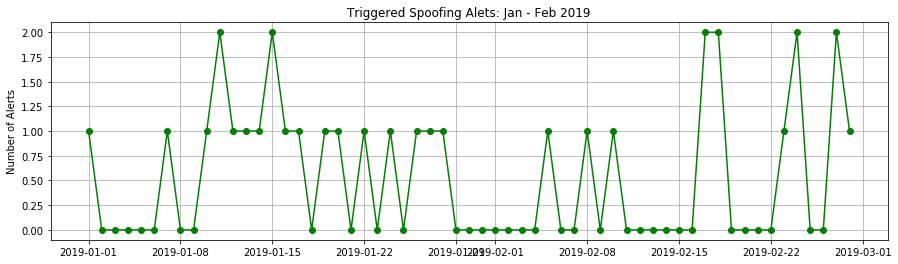

In [6]:
base = datetime.date(2019,1,1)
date_list = [base + datetime.timedelta(days=x) for x in range(0, 60-1)]
datePD = pd.DataFrame(date_list).set_index(0)

data = pd.DataFrame(newdf3['Datetime'].dt.date.value_counts())
tester = pd.concat([datePD,data['Datetime']],axis=1,sort=True).reset_index(drop=False)
tester['index2'] = pd.to_datetime(tester['index'])
tester = tester.fillna(value=0)

plt.rcParams['figure.figsize'] = (15,4)

plt.plot_date(x=tester['index2'], y=tester['Datetime'], fmt="go-",xdate=True)
plt.title(("Triggered Spoofing Alets: Jan - Feb 2019"))
plt.ylabel("Number of Alerts")
plt.grid(True)

plt.show()

#### 3) Accounts Involved & The Worst

In [7]:

washMetrics = metrics(newdf3['acc'])

print('Number of Accounts involved:', washMetrics.index.size)
print('\nWash Sales Metrics: \n', washMetrics)

Number of Accounts involved: 2

Wash Sales Metrics: 
         count    %
22440      24  75%
355845      8  25%


In [8]:
percentageAlerts = 15

worstacc = washMetrics.loc[washMetrics['%'].str.replace('%','').astype(float) >= percentageAlerts,'%'].index.tolist()
# worstacc = [22440,202474]

allacc = washMetrics.loc[washMetrics['%'].str.replace('%','').astype(float) < percentageAlerts,'%'].index.tolist()
print('Accounts Making up >= ',(percentageAlerts),'%: ',worstacc,sep='')
print('Other Accounts: ', allacc,sep='')

Accounts Making up >= 15%: ['22440', '355845']
Other Accounts: []


#### 9) Aggregate Metrics (Account Level)

In [11]:
newdf4 = fixType(newdf3.loc[newdf3['acc'] != '0'])
newdf4.head()

,Datetime,acc,security,spoofs,timeGenuine,volGenuine,volmaxSpoof,ratio,price0,price1,cumulative,countspoofs
0,2019-01-01 18:19:05,22440.0,BTCUSD,"[(18:18:59.239, 18:18:59.688, 0.5, 3748.16000)...",18:19:03.668,0.683733,10.662674,15.594795,3748.00,3756.29,54.0,12.0
1,2019-01-07 04:54:10,355845.0,BTCUSD,"[(04:54:03.035, 04:54:04.042, 0.976, 3980.4700...",04:54:08.463,0.633000,8.101000,12.797788,3980.50,3971.05,6.0,11.0
2,2019-01-10 11:09:41,22440.0,BTCUSD,"[(11:09:37.607, 11:09:39.441, 0.581234, 3705.0...",11:09:39.876,0.500000,15.245758,30.491516,3705.02,3691.09,14.0,11.0
3,2019-01-11 09:03:33,355845.0,ETHUSD,"[(09:03:26.307, 09:03:29.878, 64.052, 125.5100...",09:03:31.537,12.655000,159.613000,12.612643,125.54,124.89,8.0,15.0
4,2019-01-11 18:36:49,22440.0,BTCUSD,"[(18:36:42.458, 18:36:43.273, 0.194258, 3601.4...",18:36:47.667,0.500000,7.347763,14.695525,3601.49,3615.72,21.0,15.0


In [20]:
newdf4_sum = newdf4.groupby('acc').sum().drop(columns=['ratio','price0','price1'])
newdf4_mean = newdf4.groupby('acc').mean()['ratio']
newdf4_count = newdf4.groupby('acc').count()['security']

newdf5 = pd.concat([newdf4_sum,newdf4_mean,newdf4_count],join='outer',axis=1)
newdf5

,volGenuine,volmaxSpoof,cumulative,countspoofs,ratio,security
acc,,,,,,
22440.0,20.279007,362.872194,1528.0,1252.0,17.573390,24
355845.0,74.542000,829.592000,99.0,107.0,11.495829,8


#### 8) Aggregate Metrics (Pair Level)

In [ ]:
# alerts2Metrics = pd.concat([metrics(output['pair']),output.groupby('pair').sum().astype(int)[['passPOV','TV']].sort_values('TV',ascending=False)],axis=1,sort=False)

# alerts2Metrics['TV'] = alerts2Metrics['TV']

# print(alerts2Metrics.shape)
# alerts2Metrics